# HybridSN: Hiperspektral Görüntü Sınıflandırması için hibrit 2B-3B ESA modeli 

**Düzenleyen:** Oğuzhan AZAKLIOĞLU**

In [1]:
## Gerekli kütüphanelerin çağırılması

import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import pandas as pd
import seaborn as sns
from tqdm import tqdm

init_notebook_mode(connected=True)
%matplotlib inline

# Verilerin yüklenmesi

In [2]:
## Global Değikenler (inputlar)

dataset = 'IP'
test_ratio = 0.50
windowSize = 23

In [3]:
## Veri kümesinin çağrılması

def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [4]:
## Veri kümesini eğitim ve test olarak ayırmaya yarayan fonksiyon

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
## Boyut indirgeme yöntemi olan TBA'nın tanımlanması

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [6]:
## Padding Fonksiyonu

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
## veri kümesinin boyutları 

X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [9]:
K = X.shape[2]

In [10]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [11]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 23, 23, 30), (10249,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((5124, 23, 23, 30), (5125, 23, 23, 30), (5124,), (5125,))

# Model ve Eğitim Aşaması

In [13]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(5124, 23, 23, 30, 1)

In [14]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(5124, 16)

In [15]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [16]:
## Giriş katmanı
input_layer = Input((S, S, L, 1))

## evrişim katmanları
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## tam bağlı katmanlar
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [17]:
# modeli girdi ve çıktı katmanlarıyla tanımlama

model = Model(inputs=input_layer, outputs=output_layer)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23, 23, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 21, 21, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 19, 19, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 17, 17, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 17, 17, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 15, 64)        331840    
                                                                 
 flatten (Flatten)           (None, 14400)             0     

In [19]:
# Modelin derlenmesi
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

c:\Users\oguzh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [20]:
# kayıt noktası
filepath = (str(dataset)+"_"+str(test_ratio)+"_best_model.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=30, epochs=40, callbacks=callbacks_list)

Epoch 1/40
171/171 [==============================] - 10s 45ms/step - loss: 1.2948 - accuracy: 0.5701
Epoch 2/40
171/171 [==============================] - 8s 45ms/step - loss: 0.2351 - accuracy: 0.9374
Epoch 3/40
171/171 [==============================] - 8s 46ms/step - loss: 0.1012 - accuracy: 0.9701
Epoch 4/40
171/171 [==============================] - 8s 44ms/step - loss: 0.0833 - accuracy: 0.9748
Epoch 5/40
171/171 [==============================] - 8s 47ms/step - loss: 0.0646 - accuracy: 0.9846
Epoch 6/40
171/171 [==============================] - 8s 45ms/step - loss: 0.0420 - accuracy: 0.9897
Epoch 7/40
171/171 [==============================] - 8s 44ms/step - loss: 0.0440 - accuracy: 0.9906
Epoch 8/40
171/171 [==============================] - 8s 47ms/step - loss: 0.0396 - accuracy: 0.9926
Epoch 9/40
171/171 [==============================] - 8s 45ms/step - loss: 0.0500 - accuracy: 0.9867
Epoch 10/40
171/171 [==============================] - 8s 46ms/step - loss: 0.0517 - accur

In [22]:
model.save(str(dataset)+"_"+str(test_ratio)+"_best_model.hdf5")

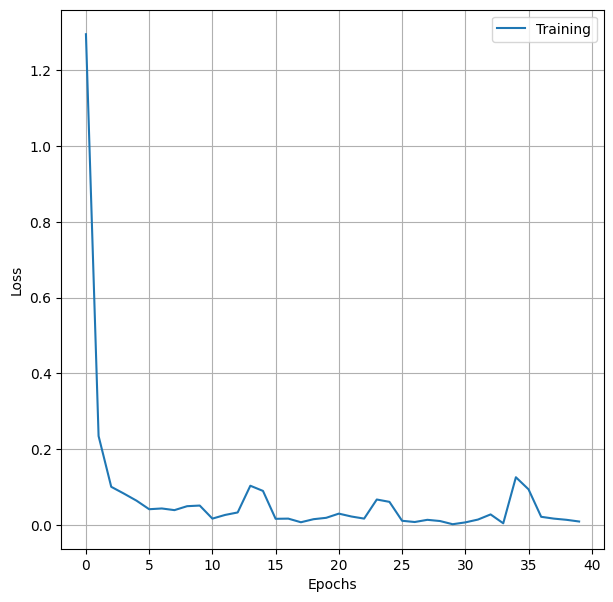

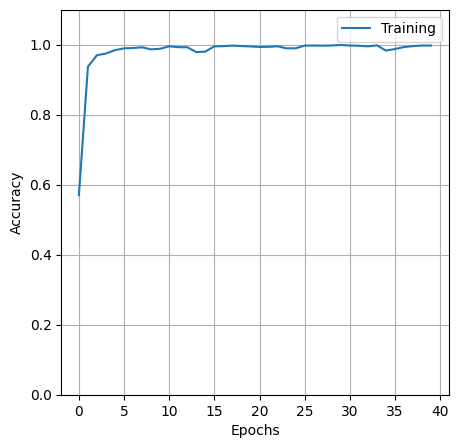

In [23]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs') 
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig(str(dataset)+"_"+str(test_ratio)+"_loss_curve.jpg")
plt.show()
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig(str(dataset)+"_"+str(test_ratio)+"_acc_curve.jpg") 
plt.show()

# Sınıflandırma sonuçlarının gözlemlenmesi

In [24]:
# load best weights
model.load_weights(str(dataset)+"_"+str(test_ratio)+"_best_model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [25]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(5125, 23, 23, 30, 1)

In [26]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(5125, 16)

In [27]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

161/161 [==============================] - 4s 19ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      0.99      1.00       714
           2       1.00      1.00      1.00       415
           3       1.00      1.00      1.00       118
           4       1.00      0.98      0.99       242
           5       0.99      1.00      1.00       365
           6       0.93      1.00      0.97        14
           7       1.00      1.00      1.00       239
           8       0.91      1.00      0.95        10
           9       1.00      1.00      1.00       486
          10       1.00      1.00      1.00      1228
          11       1.00      0.99      1.00       297
          12       0.98      1.00      0.99       102
          13       1.00      1.00      1.00       633
          14       1.00      1.00      1.00       193
          15       0.98      1.00      0.99        46

    accuracy            

In [28]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [29]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [30]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

161/161 [==============================] - 5s 25ms/step - loss: 0.0116 - accuracy: 0.9977


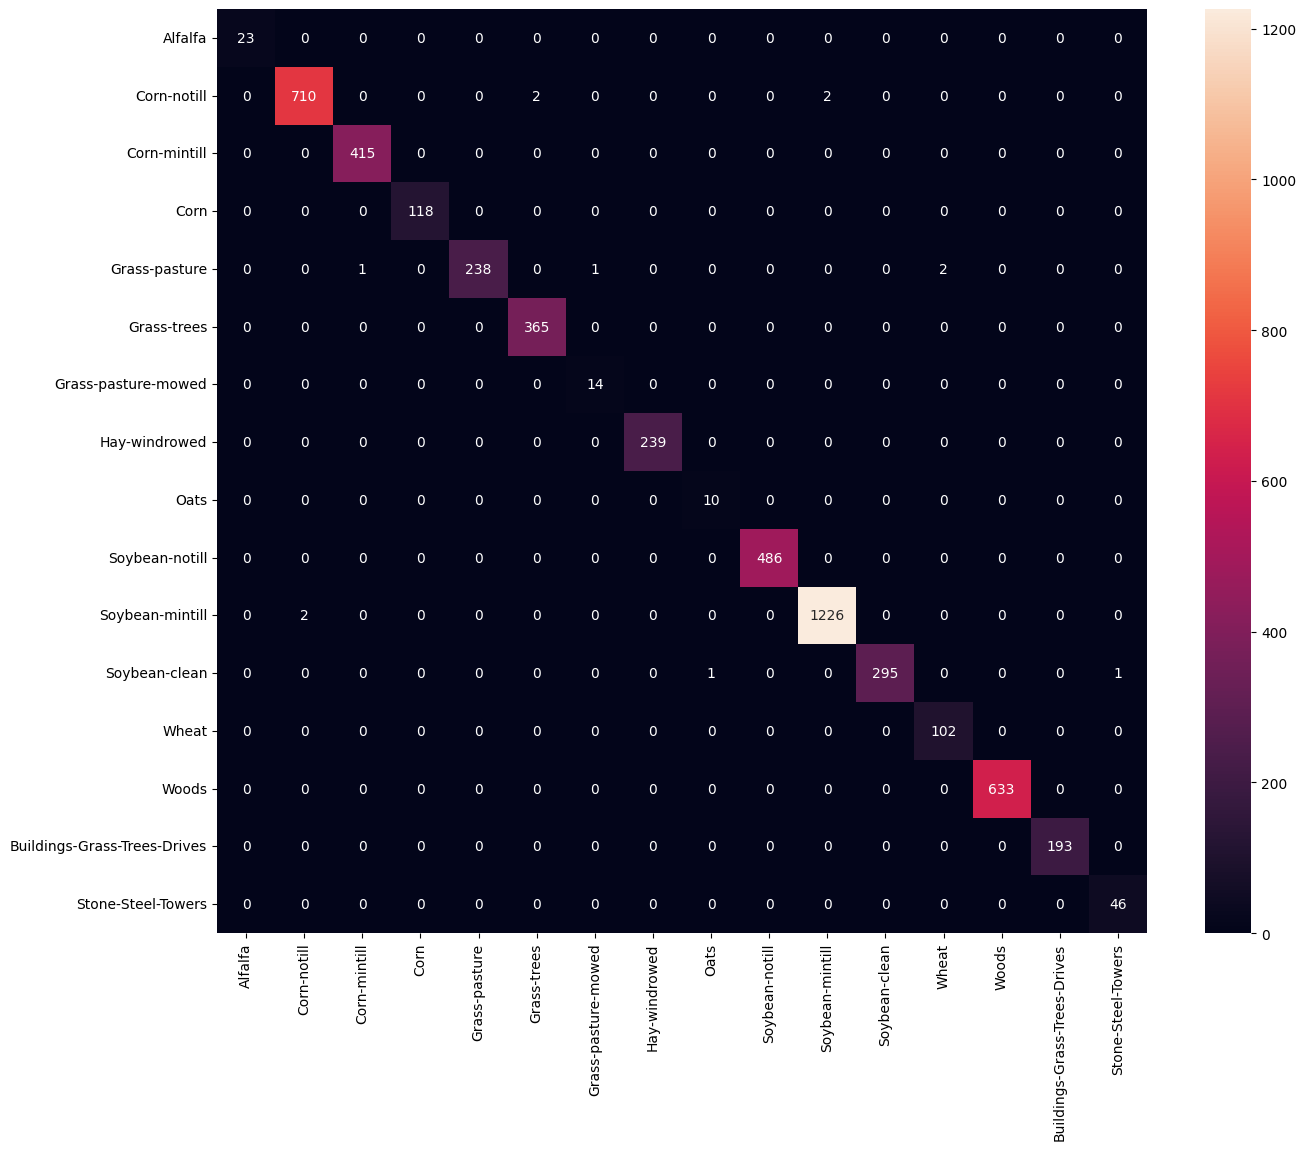

In [31]:

##Confusion matrix çizdirme

plt.figure(figsize = (15,12))

classes = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']

df_cm = pd.DataFrame(confusion, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.savefig(str(dataset)+"_"+str(test_ratio)+"_ConfMatrix.jpg", dpi=100)
plt.show()

In [32]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = str(dataset)+"_"+str(test_ratio)+"_classification_report.txt"


with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

161/161 [==============================] - 4s 22ms/step - loss: 0.0116 - accuracy: 0.9977


In [33]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [34]:
# ORJİNAL GÖRÜNTÜNÜN YÜKLENMESİ

X, y = loadData(dataset)

In [35]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [36]:
X,pca = applyPCA(X, numComponents=numComponents)

In [37]:
X = padWithZeros(X, PATCH_SIZE//2)

In [38]:
# sınıflandırma sonucunda oluşan görselin hesaplanması

outputs = np.zeros((height,width))
for i in tqdm(range(height), desc="Predictting...", ascii=False, ncols=75):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Predictting...:   0%|                              | 0/145 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Predictting...:   1%|▏                     | 1/145 [00:04<10:22,  4.32s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   1%|▎                     | 2/145 [00:08<10:18,  4.32s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:   2%|▍                     | 3/145 [00:13<10:40,  4.51s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   3%|▌                     | 4/145 [00:18<10:59,  4.67s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   3%|▊                     | 5/145 [00:23<11:12,  4.80s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   4%|▉                     | 6/145 [00:28<11:03,  4.78s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   5%|█                     | 7/145 [00:33<11:20,  4.93s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:   6%|█▏                    | 8/145 [00:38<11:40,  5.11s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:   6%|█▎                    | 9/145 [00:45<12:52,  5.68s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:   7%|█▍                   | 10/145 [00:51<13:02,  5.79s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:   8%|█▌                   | 11/145 [00:57<12:55,  5.79s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   8%|█▋                   | 12/145 [01:03<12:56,  5.84s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:   9%|█▉                   | 13/145 [01:08<12:26,  5.66s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  10%|██                   | 14/145 [01:14<12:08,  5.56s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  10%|██▏                  | 15/145 [01:19<11:53,  5.49s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  11%|██▎                  | 16/145 [01:24<11:41,  5.44s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  12%|██▍                  | 17/145 [01:29<11:12,  5.26s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  12%|██▌                  | 18/145 [01:35<11:23,  5.38s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  13%|██▊                  | 19/145 [01:40<11:27,  5.45s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  14%|██▉                  | 20/145 [01:46<11:15,  5.40s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  14%|███                  | 21/145 [01:50<10:45,  5.21s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  15%|███▏                 | 22/145 [01:55<10:11,  4.97s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  16%|███▎                 | 23/145 [01:59<09:38,  4.74s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  17%|███▍                 | 24/145 [02:03<09:10,  4.55s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  17%|███▌                 | 25/145 [02:07<08:31,  4.26s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  18%|███▊                 | 26/145 [02:10<07:48,  3.94s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  19%|███▉                 | 27/145 [02:13<07:06,  3.61s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  19%|████                 | 28/145 [02:14<05:40,  2.91s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  21%|████▎                | 30/145 [02:16<04:00,  2.09s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  21%|████▍                | 31/145 [02:22<05:36,  2.95s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  22%|████▋                | 32/145 [02:27<06:51,  3.64s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  23%|████▊                | 33/145 [02:34<08:01,  4.30s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  23%|████▉                | 34/145 [02:40<08:57,  4.84s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  24%|█████                | 35/145 [02:46<09:49,  5.36s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  25%|█████▏               | 36/145 [02:53<10:37,  5.85s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  26%|█████▎               | 37/145 [03:01<11:15,  6.26s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  26%|█████▌               | 38/145 [03:08<11:44,  6.58s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  27%|█████▋               | 39/145 [03:15<12:04,  6.83s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  28%|█████▊               | 40/145 [03:21<11:26,  6.54s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  28%|█████▉               | 41/145 [03:28<11:25,  6.59s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  29%|██████               | 42/145 [03:35<11:33,  6.74s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  30%|██████▏              | 43/145 [03:42<11:41,  6.88s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  30%|██████▎              | 44/145 [03:50<11:57,  7.10s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  31%|██████▌              | 45/145 [03:58<12:03,  7.24s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  32%|██████▋              | 46/145 [04:04<11:41,  7.09s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  32%|██████▊              | 47/145 [04:11<11:24,  6.99s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  33%|██████▉              | 48/145 [04:18<11:15,  6.96s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  34%|███████              | 49/145 [04:25<11:02,  6.90s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  34%|███████▏             | 50/145 [04:32<11:00,  6.95s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  35%|███████▍             | 51/145 [04:37<10:08,  6.47s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  36%|███████▌             | 52/145 [04:44<10:09,  6.55s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  37%|███████▋             | 53/145 [04:51<10:12,  6.66s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  37%|███████▊             | 54/145 [04:58<10:09,  6.70s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  38%|███████▉             | 55/145 [05:05<10:10,  6.78s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  39%|████████             | 56/145 [05:12<10:13,  6.90s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  39%|████████▎            | 57/145 [05:19<10:11,  6.95s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  40%|████████▍            | 58/145 [05:26<10:13,  7.05s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  41%|████████▌            | 59/145 [05:32<09:39,  6.74s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  41%|████████▋            | 60/145 [05:39<09:40,  6.83s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  42%|████████▊            | 61/145 [05:45<09:11,  6.57s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  43%|████████▉            | 62/145 [05:51<08:57,  6.48s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  43%|█████████            | 63/145 [05:57<08:37,  6.31s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  44%|█████████▎           | 64/145 [06:03<08:12,  6.08s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  45%|█████████▍           | 65/145 [06:08<07:51,  5.90s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  46%|█████████▌           | 66/145 [06:13<07:27,  5.66s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  46%|█████████▋           | 67/145 [06:19<07:10,  5.52s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  47%|█████████▊           | 68/145 [06:24<07:06,  5.54s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  48%|█████████▉           | 69/145 [06:30<07:01,  5.54s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  48%|██████████▏          | 70/145 [06:35<06:53,  5.51s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  49%|██████████▎          | 71/145 [06:41<06:44,  5.47s/it]

1/1 [==============================] - 0s 20ms/step


Predictting...:  50%|██████████▍          | 72/145 [06:43<05:37,  4.63s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  50%|██████████▌          | 73/145 [06:45<04:31,  3.78s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  51%|██████████▋          | 74/145 [06:50<05:03,  4.27s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  52%|██████████▊          | 75/145 [06:56<05:25,  4.65s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  52%|███████████          | 76/145 [07:01<05:34,  4.84s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  53%|███████████▏         | 77/145 [07:07<05:40,  5.00s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  54%|███████████▎         | 78/145 [07:12<05:43,  5.13s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  54%|███████████▍         | 79/145 [07:18<05:53,  5.36s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  55%|███████████▌         | 80/145 [07:24<05:54,  5.45s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  56%|███████████▋         | 81/145 [07:29<05:54,  5.55s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  57%|███████████▉         | 82/145 [07:35<05:53,  5.61s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  57%|████████████         | 83/145 [07:40<05:31,  5.35s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  58%|████████████▏        | 84/145 [07:44<05:12,  5.13s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  59%|████████████▎        | 85/145 [07:49<04:58,  4.98s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  59%|████████████▍        | 86/145 [07:54<04:44,  4.82s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  60%|████████████▌        | 87/145 [07:58<04:31,  4.68s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  61%|████████████▋        | 88/145 [08:02<04:18,  4.54s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  61%|████████████▉        | 89/145 [08:05<03:51,  4.13s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  62%|█████████████        | 90/145 [08:08<03:31,  3.84s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  63%|█████████████▏       | 91/145 [08:12<03:16,  3.64s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  63%|█████████████▎       | 92/145 [08:15<03:05,  3.50s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  64%|█████████████▍       | 93/145 [08:18<02:56,  3.39s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  65%|█████████████▌       | 94/145 [08:20<02:40,  3.14s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  66%|█████████████▊       | 95/145 [08:23<02:33,  3.07s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  66%|█████████████▉       | 96/145 [08:27<02:37,  3.21s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  67%|██████████████       | 97/145 [08:30<02:25,  3.03s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  68%|██████████████▏      | 98/145 [08:32<02:15,  2.89s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  68%|██████████████▎      | 99/145 [08:36<02:21,  3.07s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  69%|█████████████▊      | 100/145 [08:40<02:34,  3.42s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  70%|█████████████▉      | 101/145 [08:44<02:42,  3.70s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  70%|██████████████      | 102/145 [08:48<02:46,  3.86s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  71%|██████████████▏     | 103/145 [08:53<02:44,  3.92s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  72%|██████████████▎     | 104/145 [08:56<02:40,  3.92s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  72%|██████████████▍     | 105/145 [09:00<02:35,  3.88s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  73%|██████████████▌     | 106/145 [09:04<02:30,  3.86s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  74%|██████████████▊     | 107/145 [09:08<02:25,  3.83s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  74%|██████████████▉     | 108/145 [09:11<02:17,  3.71s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  75%|███████████████     | 109/145 [09:15<02:10,  3.62s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  76%|███████████████▏    | 110/145 [09:18<02:04,  3.54s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  77%|███████████████▎    | 111/145 [09:21<01:58,  3.48s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  77%|███████████████▍    | 112/145 [09:25<01:53,  3.43s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  78%|███████████████▌    | 113/145 [09:28<01:47,  3.37s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  79%|███████████████▋    | 114/145 [09:31<01:39,  3.21s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  79%|███████████████▊    | 115/145 [09:34<01:33,  3.13s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  81%|████████████████▏   | 117/145 [09:34<00:50,  1.80s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  81%|████████████████▎   | 118/145 [09:39<01:06,  2.45s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  82%|████████████████▍   | 119/145 [09:43<01:17,  2.97s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  83%|████████████████▌   | 120/145 [09:48<01:25,  3.41s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  83%|████████████████▋   | 121/145 [09:52<01:30,  3.78s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  84%|████████████████▊   | 122/145 [09:57<01:34,  4.09s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  85%|████████████████▉   | 123/145 [10:02<01:35,  4.35s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  86%|█████████████████   | 124/145 [10:07<01:35,  4.54s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  86%|█████████████████▏  | 125/145 [10:12<01:34,  4.70s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  87%|█████████████████▍  | 126/145 [10:16<01:21,  4.29s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  88%|█████████████████▌  | 127/145 [10:21<01:22,  4.58s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  88%|█████████████████▋  | 128/145 [10:26<01:19,  4.67s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  89%|█████████████████▊  | 129/145 [10:30<01:14,  4.69s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  90%|█████████████████▉  | 130/145 [10:35<01:10,  4.69s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  90%|██████████████████  | 131/145 [10:40<01:05,  4.69s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  91%|██████████████████▏ | 132/145 [10:45<01:00,  4.69s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  92%|██████████████████▎ | 133/145 [10:49<00:56,  4.67s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  92%|██████████████████▍ | 134/145 [10:54<00:50,  4.62s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  93%|██████████████████▌ | 135/145 [10:58<00:45,  4.58s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  94%|██████████████████▊ | 136/145 [11:01<00:35,  3.98s/it]

1/1 [==============================] - 0s 21ms/step


Predictting...:  94%|██████████████████▉ | 137/145 [11:03<00:28,  3.55s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  95%|███████████████████ | 138/145 [11:07<00:25,  3.63s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  96%|███████████████████▏| 139/145 [11:11<00:22,  3.67s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  97%|███████████████████▎| 140/145 [11:12<00:14,  2.93s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  97%|███████████████████▍| 141/145 [11:13<00:09,  2.41s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  98%|███████████████████▌| 142/145 [11:15<00:06,  2.07s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  99%|███████████████████▋| 143/145 [11:15<00:03,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...: 100%|████████████████████| 145/145 [11:15<00:00,  4.66s/it]


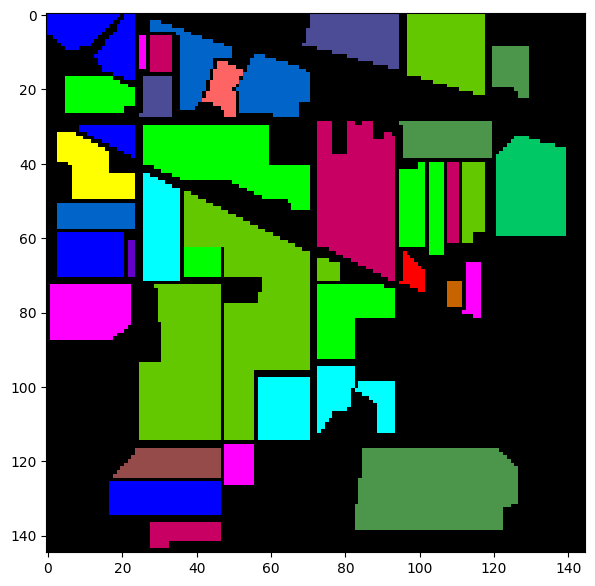

In [39]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

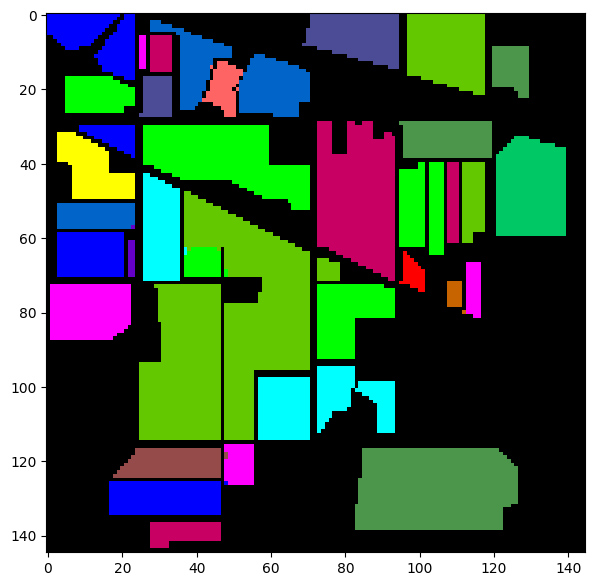

In [40]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [41]:
spectral.save_rgb(str(dataset)+"_"+str(test_ratio)+"_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [42]:
spectral.save_rgb(str(dataset)+"_"+str(test_ratio)+"_gt.jpg", y, colors=spectral.spy_colors)

#SON